In [1]:
import wfdb
import neurokit2 as nk
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight

2025-02-04 09:57:58.889323: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
base_path = '/Users/chkv/Downloads/mit-bih-arrhythmia-database-1.0.0/'
abnormal_symbols = {'L', 'R', 'A', 'V', 'F', '[', '!', ']', 'e', 'E', '/'}

In [3]:
# Parameters
segment_length = 360 * 10  # 10 seconds at 360 Hz

In [4]:
def process_record(record_name):
    record_path = base_path + record_name
    record = wfdb.rdrecord(record_path)
    annotation = wfdb.rdann(record_path, 'atr')
    
    # Use the first lead (modify if needed)
    ecg_signal = record.p_signal[:, 0]
    
    # Preprocess ECG
    ecg_cleaned = nk.ecg_clean(ecg_signal, sampling_rate=360)
    
    # Determine patient label
    abnormal_count = sum(1 for symbol in annotation.symbol if symbol in abnormal_symbols)
    total_beats = len(annotation.symbol)
    is_abnormal = 1 if (abnormal_count / total_beats) > 0.2 else 0
    
    return ecg_cleaned, is_abnormal

In [5]:
# Collect segments and labels per patient
patient_segments = {}
patient_labels = {}

for file in os.listdir(base_path):
    if file.endswith('.dat'):
        record_name = file[:-4]
        patient_id = record_name[:3]  # Adjust based on your patient ID format
        try:
            ecg_cleaned, label = process_record(record_name)
            # Segment the ECG
            num_segments = len(ecg_cleaned) // segment_length
            segments = [ecg_cleaned[i*segment_length : (i+1)*segment_length] 
                        for i in range(num_segments)]
            patient_segments[patient_id] = segments
            patient_labels[patient_id] = label
        except Exception as e:
            print(f"Error processing {record_name}: {e}")


In [6]:
# Split patients into train and test
patient_ids = list(patient_labels.keys())
y_patients = [patient_labels[pid] for pid in patient_ids]
train_ids, test_ids = train_test_split(patient_ids, test_size=0.2, random_state=42, stratify=y_patients)

# Compile training and testing data
X_train, y_train = [], []
for pid in train_ids:
    X_train.extend(patient_segments[pid])
    y_train.extend([patient_labels[pid]] * len(patient_segments[pid]))

In [7]:
X_test, y_test = [], []
for pid in test_ids:
    X_test.extend(patient_segments[pid])
    y_test.extend([patient_labels[pid]] * len(patient_segments[pid]))

In [8]:
# Convert to numpy arrays and reshape for CNN
X_train = np.array(X_train).reshape(-1, segment_length, 1)
X_test = np.array(X_test).reshape(-1, segment_length, 1)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [9]:
# Compute class weights for imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i: w for i, w in enumerate(class_weights)}

In [10]:
# Build CNN model
model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(segment_length, 1)),
    MaxPooling1D(2),
    Conv1D(128, kernel_size=3, activation='relu'),
    MaxPooling1D(2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    class_weight=class_weights
)

Epoch 1/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 108s 617ms/step - accuracy: 0.7093 - loss: 0.5864 - val_accuracy: 0.6213 - val_loss: 0.9458
Epoch 2/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 99s 580ms/step - accuracy: 0.8896 - loss: 0.2954 - val_accuracy: 0.4613 - val_loss: 1.2629
Epoch 3/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 100s 584ms/step - accuracy: 0.9357 - loss: 0.1861 - val_accuracy: 0.4050 - val_loss: 1.4162
Epoch 4/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 95s 557ms/step - accuracy: 0.9622 - loss: 0.1201 - val_accuracy: 0.4766 - val_loss: 1.4697
Epoch 5/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 94s 551ms/step - accuracy: 0.9681 - loss: 0.1052 - val_accuracy: 0.3947 - val_loss: 1.9829
Epoch 6/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 110s 642ms/step - accuracy: 0.9775 - loss: 0.0612 - val_accuracy: 0.3808 - val_loss: 2.2458
Epoch 7/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 113s 662ms/step - accuracy: 0.9827 - loss: 0.0445 - val_accuracy: 0.3692 - val_loss: 2.3972
Epoch 8/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 80s 466ms/step - accuracy: 0.9861 - los

In [12]:
# Evaluate
y_pred_prob = model.predict(X_test).ravel()
y_pred = (y_pred_prob > 0.5).astype(int)

# Metrics
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step
Confusion Matrix:
[[421 659]
 [161 559]]

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.39      0.51      1080
           1       0.46      0.78      0.58       720

    accuracy                           0.54      1800
   macro avg       0.59      0.58      0.54      1800
weighted avg       0.62      0.54      0.53      1800



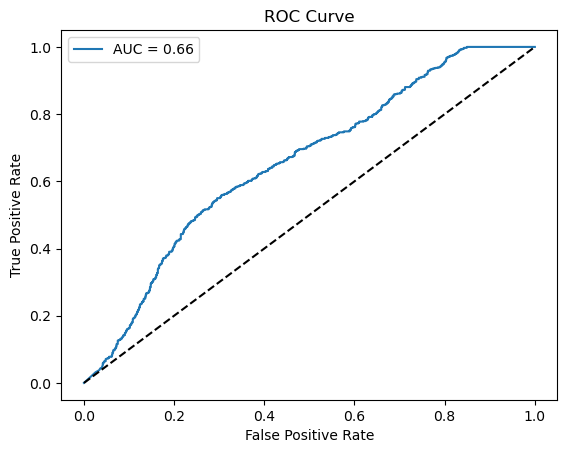

In [13]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [15]:
# Compute confusion matrix values
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

# Compute Sensitivity (Recall) and Specificity
sensitivity = tp / (tp + fn)  # Recall
specificity = tn / (tn + fp)

# Compute Precision-Recall AUC
from sklearn.metrics import precision_recall_curve, auc

precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
pr_auc = auc(recall, precision)

# Create a summary DataFrame
summary = pd.DataFrame({
    'Metric': ['Accuracy', 'Sensitivity (Recall)', 'Specificity', 'ROC AUC', 'Precision-Recall AUC'],
    'Score': [
        (tp + tn) / (tp + tn + fp + fn),
        sensitivity,
        specificity,
        roc_auc,
        pr_auc
    ]
})

print("Model Evaluation Summary:")
display(summary)


Model Evaluation Summary:


,Metric,Score
0,Accuracy,0.544444
1,Sensitivity (Recall),0.776389
2,Specificity,0.389815
3,ROC AUC,0.655718
4,Precision-Recall AUC,0.518907


In [16]:
   # Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

# Compute additional metrics
accuracy = (tp + tn) / (tp + tn + fp + fn)
sensitivity = tp / (tp + fn)  # Also called Recall
specificity = tn / (tn + fp)
precision = tp / (tp + fp)  # Positive Predictive Value (PPV)
npv = tn / (tn + fn)  # Negative Predictive Value (NPV)
f1_score = 2 * (precision * sensitivity) / (precision + sensitivity)

print(f"Accuracy: {accuracy:.4f}")
print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Negative Predictive Value (NPV): {npv:.4f}")
print(f"F1 Score: {f1_score:.4f}")


Accuracy: 0.5444
Sensitivity (Recall): 0.7764
Specificity: 0.3898
Precision: 0.4589
Negative Predictive Value (NPV): 0.7234
F1 Score: 0.5769


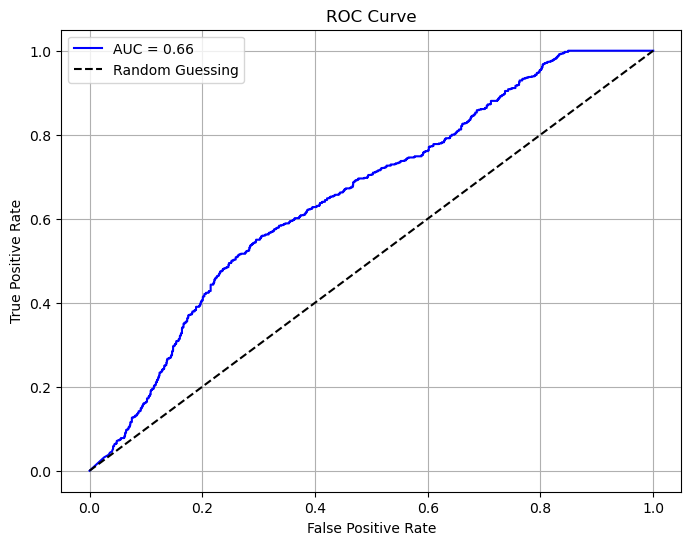

ROC AUC Score: 0.6557


In [17]:
# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()

print(f"ROC AUC Score: {roc_auc:.4f}")


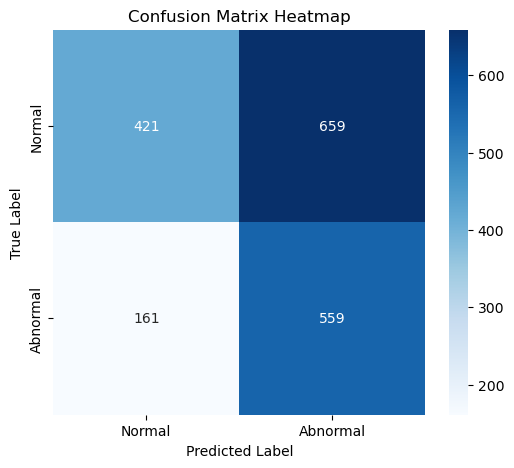

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Normal', 'Abnormal'], yticklabels=['Normal', 'Abnormal'])

# Labels and title
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix Heatmap")
plt.show()
